In [1]:
#!pip install numpy
#!pip install scipy
#!pip install torch
#!pip install torch_geometric
#!pip install matplotlib
#!pip install scikit-learn
#!pip install pandas
#!pip install git+https://github.com/alitwinkumar/connectome_tools.git
#!pip install torch_scatter
#!pip install torch_sparse

In [1]:
# Install required packages.
import os
import torch
import numpy as np
import pandas as pd
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
    

2.6.0


In [2]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [3]:
from connectome_tools import load_flywire
# Use connectome_loaders to import FlyWire neurons 
neurons, _ = load_flywire('FlyWire_data/') # datapath to FlyWire 
neurons

,root_id,group,nt_type,nt_type_score,da_avg,ser_avg,gaba_avg,glut_avg,ach_avg,oct_avg,...,class,sub_class,cell_type,hemibrain_type,hemilineage,side,nerve,J_idx,J_idx_post,J_idx_pre
0,720575940596125868,LO.LOP,ACH,0.57,0.03,0.00,0.05,0.28,0.57,0.07,...,NaN,NaN,T5c,NaN,NaN,right,NaN,0,0,0
1,720575940597856265,ME,ACH,0.85,0.01,0.00,0.03,0.04,0.85,0.07,...,NaN,NaN,Tm16,NaN,NaN,right,NaN,1,1,1
2,720575940597944841,ME.LO,ACH,0.82,0.02,0.00,0.01,0.05,0.82,0.09,...,NaN,NaN,CB3851,NaN,NaN,right,NaN,2,2,2
3,720575940598267657,ME,GABA,0.74,0.01,0.01,0.74,0.19,0.03,0.02,...,NaN,NaN,TmY15,NaN,NaN,right,NaN,3,3,3
4,720575940599333574,ME,ACH,0.61,0.02,0.00,0.13,0.13,0.61,0.11,...,NaN,NaN,Tm1,NaN,NaN,right,NaN,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139250,720575940661335681,GNG,GABA,0.71,0.00,0.00,0.71,0.17,0.11,0.00,...,NaN,NaN,CB0180,NaN,MX12__prim,left,NaN,139250,139250,139250
139251,720575940661336193,ME.LO,ACH,0.62,0.02,0.00,0.18,0.16,0.62,0.03,...,NaN,NaN,TmY3,NaN,NaN,left,NaN,139251,139251,139251
139252,720575940661337217,SCL.MB_ML,ACH,1.00,0.00,0.00,0.00,0.00,1.00,0.00,...,Kenyon_Cell,NaN,NaN,KCab-p,MBp4,left,NaN,139252,139252,139252
139253,720575940661338497,GNG,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,CB0904,NaN,putative_primary,right,PhN,139253,139253,139253


In [4]:
# Import FlyWire connections as an edgelist
connections = pd.read_csv('FlyWire_data/connections.csv')
connections

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940629970489,720575940631267655,AVLP_R,7,GABA
1,720575940605876866,720575940606514878,LAL_R,15,GABA
2,720575940627737365,720575940628914436,AL_L,32,ACH
3,720575940633587552,720575940626452879,SMP_R,15,ACH
4,720575940616871878,720575940621203973,AVLP_L,13,GABA
...,...,...,...,...,...
3869873,720575940621773517,720575940611139733,PVLP_R,1,ACH
3869874,720575940622734576,720575940609171395,ICL_L,2,ACH
3869875,720575940638466367,720575940627036426,LO_L,5,ACH
3869876,720575940629789660,720575940631553603,GOR_R,3,ACH


In [5]:
# Restrict dataset to a specific neuropil 
#neuropil_of_interest = 'LH_L'
#connections = connections[connections['neuropil'] == neuropil_of_interest] # Filter connections in edgelist by neuropil of interest
neuropils_of_interest = ['LH_L']
connections = connections[connections['neuropil'].isin(neuropils_of_interest)]

lh_neurons = list(np.unique(list(connections['pre_root_id']) + list(connections['post_root_id']))) # Subselect neurons in neuropil of interest
neurons = neurons[neurons['root_id'].isin(lh_neurons)]

#print('Number of neurons in ' + neuropils_of_interest + ': ' + str(len(neurons)))

In [6]:
neurons['super_class'].value_counts()

super_class
central               3748
visual_projection      245
ascending               37
visual_centrifugal      19
descending              17
optic                    1
Name: count, dtype: int64

In [7]:
# Edge attributes: The strength of connectivity (synaptic count) of each connection
connections = connections.astype({"syn_count": 'float32'})

In [9]:
import networkx as nx

In [82]:
# networkx graph -> PyTorch geometric object transformation is easy
G = nx.DiGraph() # Initialize a networkx directed graph 
G = nx.from_pandas_edgelist(connections, 'pre_root_id', 'post_root_id', ['syn_count'], create_using=nx.DiGraph()) # Create a graph with our node and edge information
#G = nx.from_pandas_edgelist(connections, 'pre_root_id', 'post_root_id', create_using=nx.DiGraph()) # Create a graph with our node and edge information

In [83]:
from torch_geometric.utils.convert import from_networkx
# Convert graph into PyTorch geometric object
graph = from_networkx(G, group_edge_attrs=['syn_count']) # Add edge attributes from networkx graph
#graph = from_networkx(G) # Add edge attributes from networkx graph

In [84]:
graph.y = torch.from_numpy(np.copy(pd.Categorical(neurons['super_class']).codes)).long()

In [85]:
num_classes = len(graph.y.unique())

In [86]:
import torch.nn.functional as F

graph.x = F.one_hot(graph.y, num_classes=num_classes).float()
#graph.x = torch.randn_like(graph.x)

In [87]:
def mask_features(X, mask_prob=0.7):
    mask = torch.rand(X.size(0)) < mask_prob
    X[mask] = 0.0
    return X

In [88]:
graph.x = mask_features(graph.x )
# Smoothed one-hot
#graph.x = 0.9 * graph.x + 0.1 / num_classes

In [89]:
# from torch_geometric.transforms import GDC

# gdc = GDC(
#     self_loop_weight=1,
#     normalization_in='sym',
#     normalization_out='col',
#     diffusion_kwargs=dict(method='ppr', alpha=0.15, eps=1e-4),
#     sparsification_kwargs=dict(method='threshold', eps=1e-4),
#     exact=True
# )

In [90]:
from torch_sparse import spmm

In [91]:
#graph.edge_attr = graph.edge_attr.squeeze(-1)

In [92]:
# # 1) Apply GDC to get a diffused adjacency:
# data_diffused = gdc(graph)  # This modifies edge_index, edge_attr in a new Data object.

# # data_diffused.edge_index is the "diffused" adjacency structure
# # data_diffused.edge_attr (if not None) are the corresponding weights

# # 2) Multiply the new adjacency by your features:
# edge_index = data_diffused.edge_index
# edge_weight = data_diffused.edge_attr  # or None if unweighted
# X = graph.x

# # spmm performs sparse matrix multiplication:  X_new = A * X
# # where A is encoded by (edge_index, edge_weight)
# X_diffused = spmm(edge_index, edge_weight, X.size(0), X.size(0), X)

# # Now X_diffused has the "diffused" features for each node
# graph.x = X_diffused  # Overwrite original features if desired

In [93]:
torch.sum(graph.x[0])

tensor(0.)

In [94]:
import numpy as np

In [95]:
num_features = graph.x.shape[1]
num_nodes = graph.x.shape[0]

In [96]:
num_features

6

In [97]:
num_nodes

4067

In [98]:
num_classes

6

In [99]:
def compute_homophily(edge_index, y):
    src, dst = edge_index
    same_label = (y[src] == y[dst])
    return same_label.sum().item() / same_label.numel()


In [100]:
homophily = compute_homophily(graph.edge_index, graph.y)
print(f"Homophily: {homophily:.4f}")


Homophily: 0.8632


In [101]:
import torch_geometric.transforms as T

# Define the transform
transform = T.RandomNodeSplit(split='train_rest', num_val=0.1, num_test=0.2, num_train_per_class=20)

# Apply it to your graph
graph = transform(graph)


In [102]:
#from torch_geometric.transforms import NormalizeFeatures

#transform = NormalizeFeatures()
#graph = transform(graph)

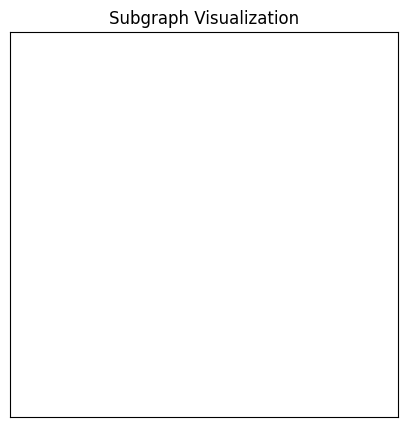

In [103]:
from torch_geometric.utils import subgraph, to_networkx
import networkx as nx

# Draw subgraph
plt.figure(figsize=(5, 5))
#nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=100, font_size=8)
plt.xticks([])
plt.yticks([])
plt.title("Subgraph Visualization")
plt.show()

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a neuron solely based on its content, *i.e.* its actvity feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [104]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=6, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=6, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [105]:
# Compute class weights
label_counts = torch.bincount(graph.y[graph.train_mask])
class_weights = 1.0 / label_counts.float()
class_weights = class_weights / class_weights.sum()  # normalize if you want

In [106]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(graph.x)  # Perform a single forward pass.
      loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(graph.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[graph.test_mask] == graph.y[graph.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(graph.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 1001):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.7950
Epoch: 002, Loss: 1.7872
Epoch: 003, Loss: 1.7800
Epoch: 004, Loss: 1.7730
Epoch: 005, Loss: 1.7662
Epoch: 006, Loss: 1.7595
Epoch: 007, Loss: 1.7528
Epoch: 008, Loss: 1.7460
Epoch: 009, Loss: 1.7391
Epoch: 010, Loss: 1.7320
Epoch: 011, Loss: 1.7248
Epoch: 012, Loss: 1.7174
Epoch: 013, Loss: 1.7097
Epoch: 014, Loss: 1.7018
Epoch: 015, Loss: 1.6936
Epoch: 016, Loss: 1.6852
Epoch: 017, Loss: 1.6767
Epoch: 018, Loss: 1.6678
Epoch: 019, Loss: 1.6585
Epoch: 020, Loss: 1.6491
Epoch: 021, Loss: 1.6396
Epoch: 022, Loss: 1.6298
Epoch: 023, Loss: 1.6197
Epoch: 024, Loss: 1.6095
Epoch: 025, Loss: 1.5991
Epoch: 026, Loss: 1.5886
Epoch: 027, Loss: 1.5778
Epoch: 028, Loss: 1.5669
Epoch: 029, Loss: 1.5561
Epoch: 030, Loss: 1.5452
Epoch: 031, Loss: 1.5343
Epoch: 032, Loss: 1.5235
Epoch: 033, Loss: 1.5127
Epoch: 034, Loss: 1.5019
Epoch: 035, Loss: 1.4912
Epoch: 036, Loss: 1.4807
Epoch: 037, Loss: 1.4703
Epoch: 038, Loss: 1.4603
Epoch: 039, Loss: 1.4505
Epoch: 040, Loss: 1.4409


In [107]:
out = model(graph.x)

In [108]:
out[graph.train_mask].shape

torch.Size([2847, 6])

In [109]:
graph.y[graph.train_mask].shape

torch.Size([2847])

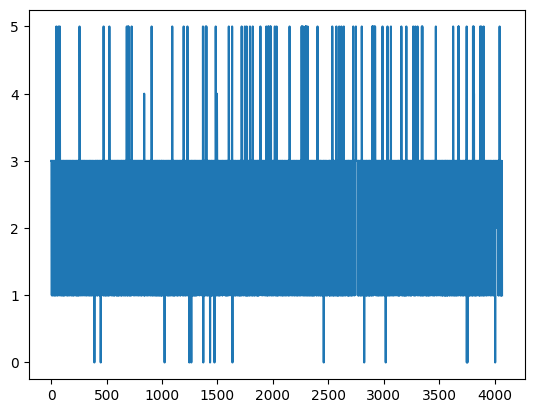

In [110]:
plt.plot(out.argmax(dim=1))

After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [111]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.2977


## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [112]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(6, 16)
  (conv2): GCNConv(16, 6)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

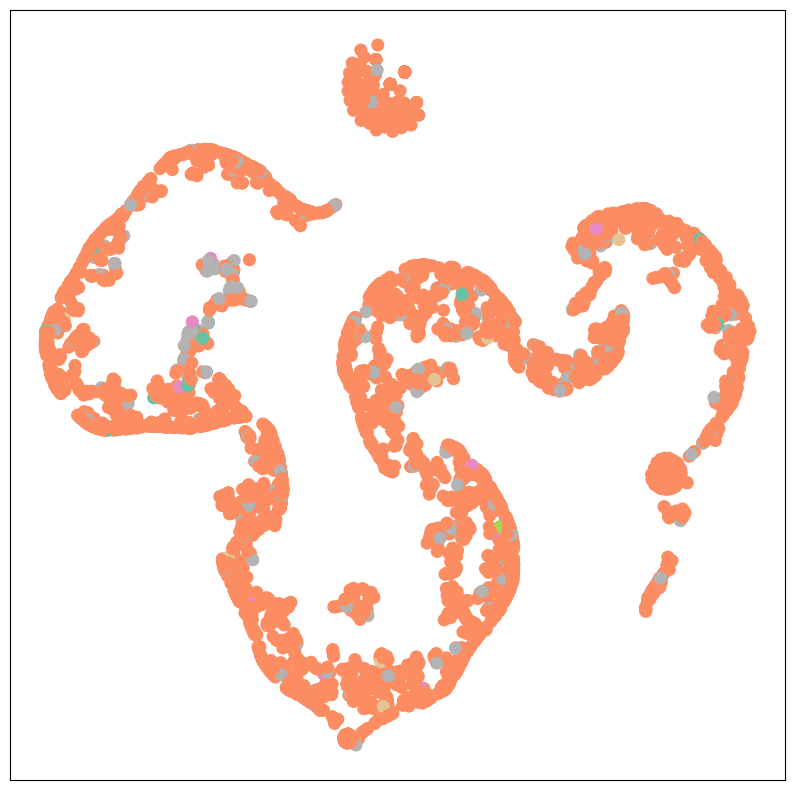

In [113]:
model = GCN(hidden_channels=16)
model.eval()

out = model(graph.x, graph.edge_index)
visualize(out, color=graph.y)

We certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

In [114]:
#graph.edge_index = torch.empty((2, 0), dtype=torch.long)

In [115]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(graph.x, graph.edge_index)  # Perform a single forward pass.
      loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(graph.x, graph.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[graph.test_mask] == graph.y[graph.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(graph.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 1001):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.8031
Epoch: 002, Loss: 1.7966
Epoch: 003, Loss: 1.7918
Epoch: 004, Loss: 1.7881
Epoch: 005, Loss: 1.7852
Epoch: 006, Loss: 1.7826
Epoch: 007, Loss: 1.7799
Epoch: 008, Loss: 1.7771
Epoch: 009, Loss: 1.7742
Epoch: 010, Loss: 1.7712
Epoch: 011, Loss: 1.7679
Epoch: 012, Loss: 1.7647
Epoch: 013, Loss: 1.7617
Epoch: 014, Loss: 1.7586
Epoch: 015, Loss: 1.7554
Epoch: 016, Loss: 1.7526
Epoch: 017, Loss: 1.7497
Epoch: 018, Loss: 1.7467
Epoch: 019, Loss: 1.7436
Epoch: 020, Loss: 1.7404
Epoch: 021, Loss: 1.7373
Epoch: 022, Loss: 1.7342
Epoch: 023, Loss: 1.7310
Epoch: 024, Loss: 1.7277
Epoch: 025, Loss: 1.7243
Epoch: 026, Loss: 1.7208
Epoch: 027, Loss: 1.7173
Epoch: 028, Loss: 1.7138
Epoch: 029, Loss: 1.7103
Epoch: 030, Loss: 1.7067
Epoch: 031, Loss: 1.7032
Epoch: 032, Loss: 1.6996
Epoch: 033, Loss: 1.6961
Epoch: 034, Loss: 1.6924
Epoch: 035, Loss: 1.6887
Epoch: 036, Loss: 1.6851
Epoch: 037, Loss: 1.6815
Epoch: 038, Loss: 1.6779
Epoch: 039, Loss: 1.6743
Epoch: 040, Loss: 1.6707


In [116]:
out = model(graph.x, graph.edge_index)

In [117]:
torch.bincount(out.argmax(dim=1))

tensor([451, 990, 993, 389, 953, 291])

In [118]:
torch.bincount(graph.y)

tensor([  37, 3748,   17,    1,   19,  245])

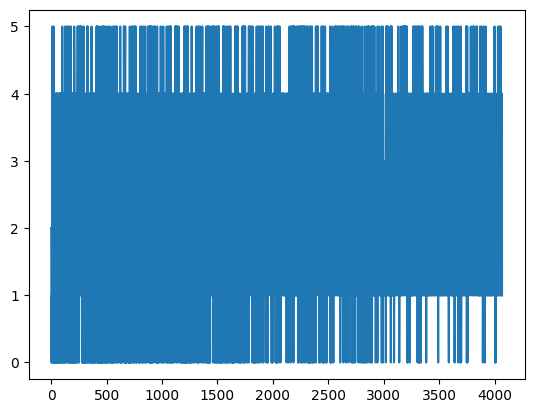

In [119]:
plt.plot(out.argmax(dim=1))

After training the model, we can check its test accuracy:

In [120]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.2620


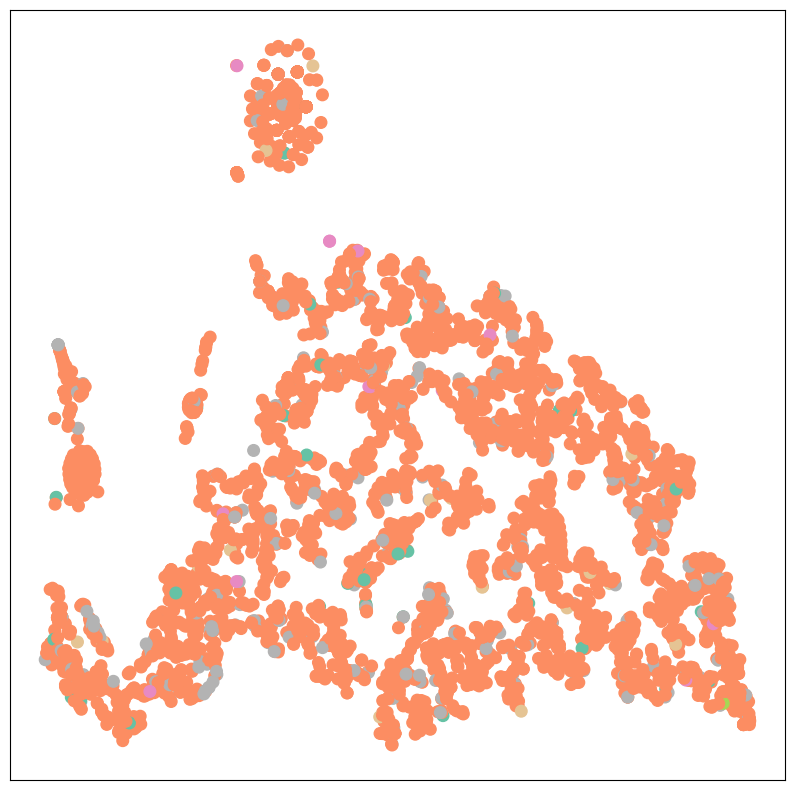

In [125]:
model.eval()

out = model(graph.x, graph.edge_index)
visualize(out, color=graph.y)

In [126]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# Assuming num_features and num_classes are defined globally
# e.g., num_features = dataset.num_features, num_classes = dataset.num_classes

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(num_features, hidden_channels, heads=8, dropout=0.0)
        # Output dim of conv1 is hidden_channels * heads, so we set in_channels accordingly
        self.conv2 = GATConv(hidden_channels * 8, num_classes, heads=1, concat=False, dropout=0.0)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        #x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=16)
print(model)

GAT(
  (conv1): GATConv(6, 16, heads=8)
  (conv2): GATConv(128, 6, heads=1)
)


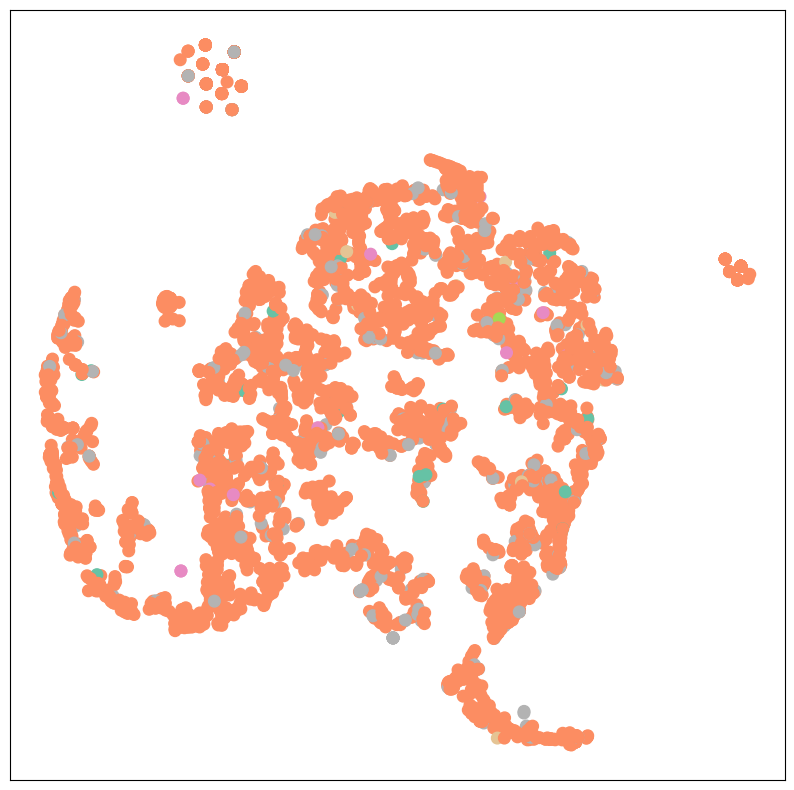

In [127]:
model = GAT(hidden_channels=16)
model.eval()

out = model(graph.x, graph.edge_index)
visualize(out, color=graph.y)

In [128]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GAT(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(graph.x, graph.edge_index)  # Perform a single forward pass.
      loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(graph.x, graph.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[graph.test_mask] == graph.y[graph.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(graph.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 1001):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.7937
Epoch: 002, Loss: 1.7829
Epoch: 003, Loss: 1.7714
Epoch: 004, Loss: 1.7606
Epoch: 005, Loss: 1.7506
Epoch: 006, Loss: 1.7407
Epoch: 007, Loss: 1.7309
Epoch: 008, Loss: 1.7211
Epoch: 009, Loss: 1.7112
Epoch: 010, Loss: 1.7012
Epoch: 011, Loss: 1.6911
Epoch: 012, Loss: 1.6807
Epoch: 013, Loss: 1.6700
Epoch: 014, Loss: 1.6593
Epoch: 015, Loss: 1.6487
Epoch: 016, Loss: 1.6385
Epoch: 017, Loss: 1.6283
Epoch: 018, Loss: 1.6174
Epoch: 019, Loss: 1.6071
Epoch: 020, Loss: 1.5971
Epoch: 021, Loss: 1.5880
Epoch: 022, Loss: 1.5794
Epoch: 023, Loss: 1.5706
Epoch: 024, Loss: 1.5617
Epoch: 025, Loss: 1.5517
Epoch: 026, Loss: 1.5418
Epoch: 027, Loss: 1.5307
Epoch: 028, Loss: 1.5199
Epoch: 029, Loss: 1.5089
Epoch: 030, Loss: 1.4987
Epoch: 031, Loss: 1.4898
Epoch: 032, Loss: 1.4810
Epoch: 033, Loss: 1.4725
Epoch: 034, Loss: 1.4646
Epoch: 035, Loss: 1.4586
Epoch: 036, Loss: 1.4568
Epoch: 037, Loss: 1.4516
Epoch: 038, Loss: 1.4398
Epoch: 039, Loss: 1.4416
Epoch: 040, Loss: 1.4356


In [129]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5031


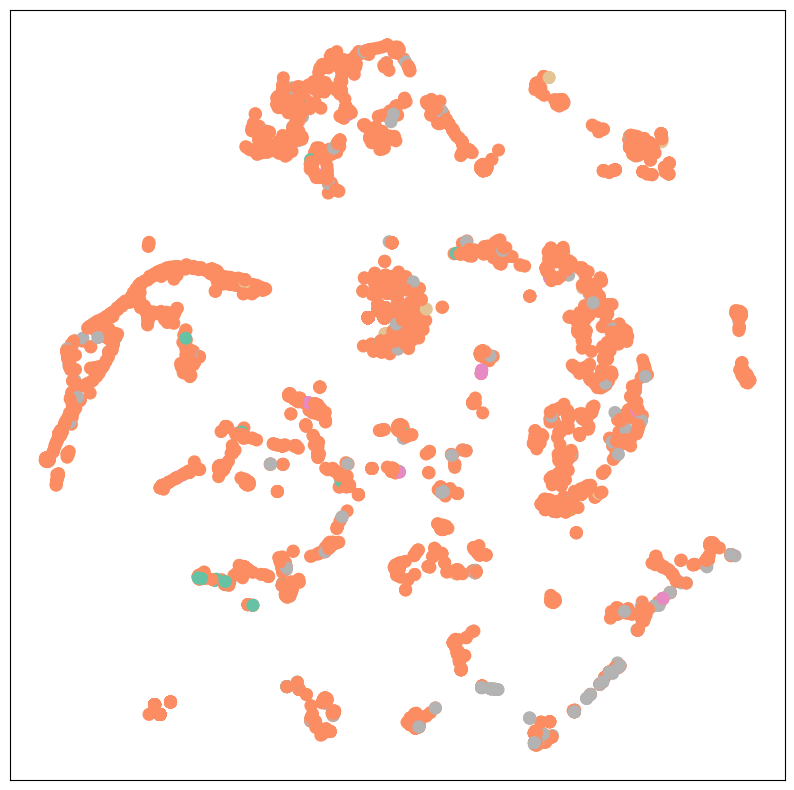

In [130]:
model.eval()

out = model(graph.x, graph.edge_index)
visualize(out, color=graph.y)